## Imports

In [1]:
import numpy as np
import networkx as nx
from qibo import matrices
from qibo.hamiltonians import Hamiltonian
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## MAXcut Hamiltonian

In [127]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph)

    ham = np.zeros(shape=(2**nqubits,2**nqubits), dtype=np.complex128)
    for i in range(nqubits):
        for j in range(nqubits):
            h = np.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = np.kron(h, matrices.Z)
                else:
                    h = np.kron(h, matrices.I)            
            M = np.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    matrix = - 1/norm * ham
    
    return Hamiltonian(nqubits, matrix, numpy=True)


def Qu(beta, r, eps=1e-3):
    return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)

## Cross-check results and plots

In [129]:
%%time
bstep = 5
K = 0.3
normE = 40
ntemp = 20
reali = 100
nmax = 9

Q = np.zeros(shape=(nmax-1, ntemp))
Qn = np.zeros(shape=(nmax-1, ntemp))
Qaa = np.zeros(shape=(nmax-1, ntemp))
Qeff = np.zeros(shape=(nmax-1, ntemp))

for n in range(2, nmax+1):

    print("n =",n)
    
    for _ in range(reali):
        H = maxcut(n, norm=normE, random_graph=True)
        energy = np.real(H.eigenvalues())
        lmin = np.min(energy)
        lmax = np.max(energy)

        for p in range(ntemp):
            bh = (p+1) * bstep
            r = np.int64(np.round(K * bh))            
            beta = bh/r*np.ones(r) * np.arange(1, r+1)
            Qbeta = np.ceil(Qu(np.hstack([beta[0], np.diff(beta)]), r))
                    
            Zbeta = np.sum(np.exp(-beta.reshape(-1,1)[:-1] * energy.reshape(1,-1)), axis=1)
            Psbeta = Zbeta / np.exp(-beta[:-1]*lmin) / 2**n
            Qr = np.sum(Psbeta * Qbeta[1:]) + Qbeta[0]
            Qeffr = 1 + np.sum(Psbeta)            
            Zbeta = np.sum(np.exp(-beta[r-1]*energy))
            Psbeta = Zbeta / np.exp(-beta[r-1]*lmin) / 2**n
            
            coeff = 1/Psbeta
            Quconst = Qu(bh, 1)
            Qeff[n-2, p] += Qeffr * Qu(bh/r, r)
            Q[n-2,p] += coeff * Qr
            Qn[n-2,p] += coeff * Quconst
            Qaa[n-2,p] += np.sqrt(1/Psbeta) * Quconst
            
Q /= reali
Qn /= reali
Qaa /= reali
Qeff /= reali

n = 2
n = 3
n = 4
n = 5
n = 6
n = 7
n = 8
n = 9
CPU times: user 2min 35s, sys: 927 ms, total: 2min 36s
Wall time: 1min 56s


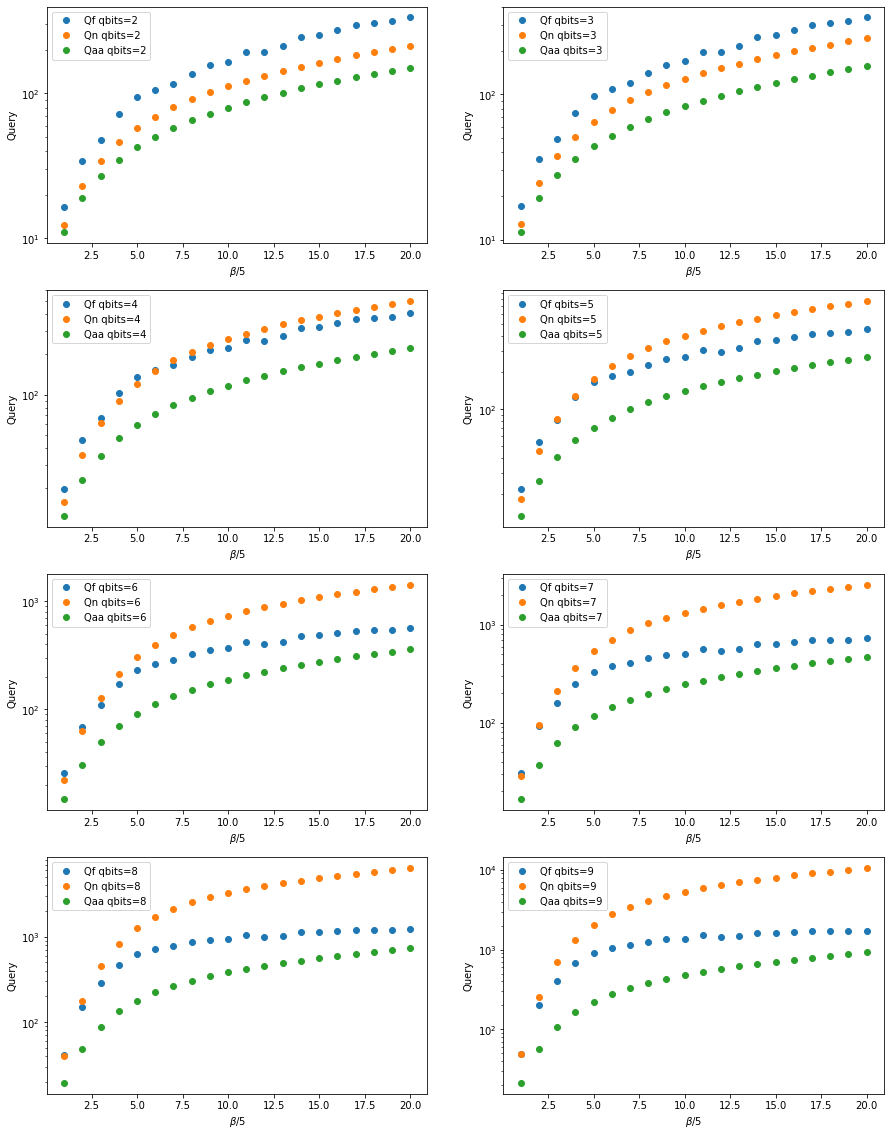

In [130]:
fig, axs = plt.subplots(4, 2, figsize=(15,20))
axs = axs.flatten()
for i in range(2,nmax+1):
    b = range(1,ntemp+1)
    axs[i-2].plot(b, Q[i-2], 'o', label='Qf qbits=%d' % i)
    axs[i-2].plot(b, Qn[i-2], 'o', label='Qn qbits=%d' % i)
    axs[i-2].plot(b, Qaa[i-2], 'o', label='Qaa qbits=%d' % i)
    axs[i-2].legend()
    axs[i-2].set_yscale('log')
    axs[i-2].set_ylabel('Query');
    axs[i-2].set_xlabel('$\\beta / 5$');

Text(0, 0.5, 'Query')

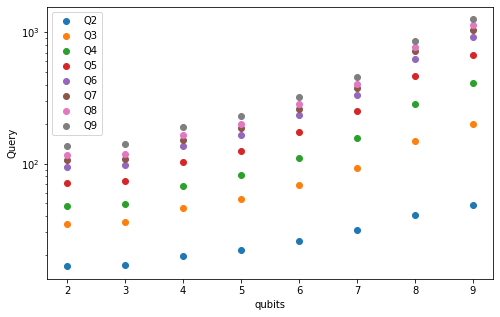

In [131]:
plt.figure(figsize=(8,5))
for i in range(2, nmax+1):
    plt.plot(range(2, nmax+1), Q[:,i-2], 'o', label='Q%s' % i)
plt.yscale('log')
plt.legend()
plt.xlabel('qubits')
plt.ylabel('Query')